# Installs and imports

In [ ]:
!pip install tensorflow_text
!pip install simpleneighbors

In [ ]:
import glob
import json
import itertools
import random
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [ ]:
import os
import pandas as pd
import sklearn.metrics.pairwise

In [ ]:
import tensorflow as tf
from tensorflow_text import SentencepieceTokenizer
import tensorflow.compat.v2 as tf
import tensorflow_hub as hub

In [ ]:
random.seed(420)
np.random.seed(420)
tf.random.set_seed(420)

# Loading the corpora

In [ ]:
maps = glob.glob("<YOUR_PATH>/US2016D1reddit/*.json")

In [ ]:
len(maps)

79

# Functions for extracting argument pairs, sentence embeddings and calculating similarity

In [ ]:
def aduPairs(edgePairs, nodesById):
    aduPair = []
    for pair in edgePairs.values():
        for p in pair['premises']:
          aduPair.append([nodesById[pair['conclusion']['toID']]['text'], nodesById[p['fromID']]['text']])
    return(aduPair)

In [ ]:
def conclusionPremiseDict(premises, conclusions):
    pairs = {}
    for i, x in enumerate(conclusions):
        pairs[i] = {'conclusion':x, 'premises':[]}
        id_to = x['fromID']
        for p in premises:
            if p['toID'] == id_to:
                pairs[i]['premises'].append(p)
                
    return pairs

In [ ]:
def pairs(map):
    with open(map) as f:
        data = json.loads(f.read())
    #Creating nodesById dictionary which has nodeID as key and whole node as value for more efficient data extraction.
    nodesById = {}
    for _, node in enumerate(data['nodes']):
        nodesById[node['nodeID']] = node
        
    #Premises are nodes that have ingoing edges that are type 'RA' and outgoing edges that are type 'I'.
    premises = [x for x in data['edges'] if nodesById[x['fromID']]['type'] == 'I' and nodesById[x['toID']]['type'] == 'RA' ]

    #Conclusions are nodes that have ingoing edges that are type 'I' and outgoing edges that are type 'RA'.
    conclusions = [x for x in data['edges'] if nodesById[x['toID']]['type'] == 'I' and nodesById[x['fromID']]['type'] == 'RA' ]
    edgePairs = conclusionPremiseDict(premises, conclusions)
    adus = aduPairs(edgePairs, nodesById)
    return adus, conclusions, premises, nodesById

In [ ]:
def comb(conclusions, premises, l, nodesById):
    combList = [(x,y) for x in conclusions for y in premises] 
    smallCombList = []
    for _ in range(l):
        p = random.choice(combList)
        smallCombList.append([nodesById[p[0]['toID']]['text'], nodesById[p[1]['fromID']]['text']])
    return smallCombList

In [ ]:
def get_similarity(embeddings_1, embeddings_2):
  """Calculate cosine simiarity between two vectors.
     *[check similarity measure based on arccos]
     
     Args:
         - embeddings1, embeddings2 - vectors with sentence|word embeddings
         
     Returns:
         - sim, cosine - similarity measures
  """
  cosine = sklearn.metrics.pairwise.cosine_similarity(embeddings_1, embeddings_2)
  sim = 1 - np.arccos(cosine)/np.pi
  return sim, cosine

In [ ]:
def embed_text(text, model):
  """Embed text as an embedding via universal sentence encoder model.
     Args:
         - text - text to encode
         - model - universal sentence encoder model 

    Returns:
         - vector embedding of text
  """
  return model(text)

In [ ]:
def embed_pair(pair, model):
  """Embed conclusion and premises from one pair.
  
  Args:
    - pair - dictionary of conclusion and premises
    
  Returns:
    - embed_conclusion - embedding of conclusion
    - embed_premises - embedding of premises
  """
  embed_conclusion = embed_text(pair[0], model)
  embed_premise = embed_text(pair[1],model)
  return embed_conclusion, embed_premise

In [ ]:
def getsimforpair(prem,conc):
  """Given premise and conclusion returns similarity measure

  Args:
      - prem - embeded representation of the premise
      - conc - embeded representation of the conclusion
  Returns: 
      - sim_pair - similarity measure
  """
  sim_pair = get_similarity(prem,conc)
  return sim_pair

In [ ]:
def loopallpairs(pairlist):
  """Given list of pairs of premises and conclusions returns list of similarity measures for each pair in the corpus

  Args:
      - pairlist - list of pairs of premises and conclusions (raw text)
  Returns: 
      - simlist - list of similarity measure for each pair (raw text)
  """
  simlist = []
  for pair in pairlist:
    conc = embed_text(pair[0], model)
    prem = embed_text(pair[1], model)
    simforpair = getsimforpair(prem,conc)
    simlist.append(simforpair)
  return simlist

In [ ]:
def makesimlist(simlist,label, measure):
  """
    Given list of list of similarity measure for each pairs makes list of similarity measurements plus labels
  
  Args:
    - simlist - list of similarity measure for each pair
    - schemelist - list of scheme for each pair
    - label (0 false, 1 for true, 2 for no label)
    - measure: 0 or 1 (sim or cosine)
  """
  simtable = pd.DataFrame(simlist)
  simlistsim = simtable[measure] 
  simlistsim_flattened = [val for sublist in simlistsim for val in sublist]
  simtable = pd.DataFrame(simlistsim_flattened)
  simtable["label"] = label
  return simtable

#Extracting arguments from the corpora

In [ ]:
truePairs = []
conclusions = []
premises = []
nodesById = {}

for m in maps:
    adus, c, p, n = pairs(m)
    truePairs.extend(adus)
    conclusions.extend(c)
    premises.extend(p)
    nodesById = {**nodesById, **n}

Creating false pairs

In [ ]:
falsePairs = comb(conclusions, premises, len(truePairs), nodesById)

# Loading a language module

In [ ]:
# The 16-language multilingual module
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3' #@param ['https://tfhub.dev/google/universal-sentence-encoder-multilingual/3', 'https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3']
model = hub.load(module_url)

# Sentence embeddings and calcualting semantic similarity 

In [ ]:
all_true_pairssimlist = loopallpairs(truePairs)

In [ ]:
all_false_pairssimlist = loopallpairs(falsePairs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in arccos
  if sys.path[0] == '':


In [ ]:
all_true_pairssimlistSIMtable = makesimlist(all_true_pairssimlist,"1",0)
 
all_true_pairssimlistCOStable = makesimlist(all_true_pairssimlist,"1",1)
all_false_pairssimlistSIMtable = makesimlist(all_false_pairssimlist,"0",0)
 
all_false_pairssimlistCOStable = makesimlist(all_false_pairssimlist,"0",1)

In [ ]:
all_pairssimlistSIMtable = pd.concat([all_true_pairssimlistSIMtable,all_false_pairssimlistSIMtable])

all_pairssimlistCOStable = pd.concat([all_true_pairssimlistCOStable,all_false_pairssimlistCOStable])

In [ ]:
all_pairssimlistSIMtable = shuffle(all_pairssimlistSIMtable)

all_pairssimlistCOStable = shuffle(all_pairssimlistCOStable)

In [ ]:
all_pairssimlistCOStable

,0,label
444,0.082801,0
139,0.099181,1
330,0.152929,0
496,0.471417,1
100,0.107943,0
...,...,...
372,0.110555,0
77,0.124140,0
318,0.317972,1
141,0.211144,0


# Desriptive statistics

In [ ]:
all_true_pairssimlistSIMtable.describe().round(3)

,0
count,567.000
mean,0.633
std,0.074
min,0.486
25%,0.570
50%,0.639
75%,0.682
max,0.875


In [ ]:
all_true_pairssimlistCOStable.describe().round(3)

,0
count,567.000
mean,0.394
std,0.207
min,-0.043
25%,0.217
50%,0.422
75%,0.541
max,0.924


In [ ]:
all_false_pairssimlistSIMtable.describe().round(3)

,0
count,566.000
mean,0.561
std,0.047
min,0.485
25%,0.527
50%,0.549
75%,0.586
max,0.735


In [ ]:
all_false_pairssimlistCOStable.describe().round(3)

,0
count,567.000
mean,0.189
std,0.145
min,-0.047
25%,0.083
50%,0.154
75%,0.268
max,1.000


# Visualization of semantic similarity

In [ ]:
dataSIM = [all_true_pairssimlistSIMtable[0], all_false_pairssimlistSIMtable[0]]

In [ ]:
dataCOS = [all_true_pairssimlistCOStable[0], all_false_pairssimlistCOStable[0]]

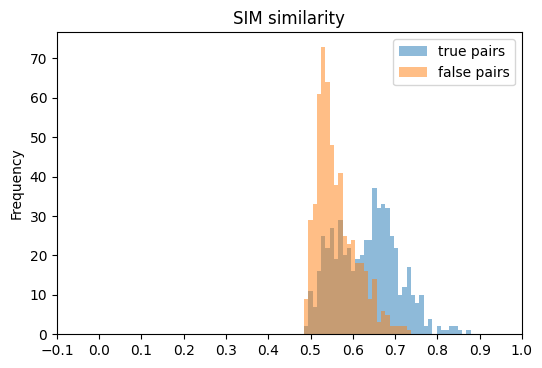

In [ ]:
bins = np.linspace(0, 1, 100)

plt.figure(dpi=100)
plt.hist(all_true_pairssimlistSIMtable[0], bins, alpha=0.5, label='true pairs', )
plt.hist(all_false_pairssimlistSIMtable[0], bins, alpha=0.5, label='false pairs')

plt.xlim(-0.1, 1.0)
plt.xticks(np.arange(-0.1, 1.01, step=0.1))

plt.legend(loc='upper right')
plt.title("SIM similarity") 
plt.ylabel("Frequency")

plt.show()

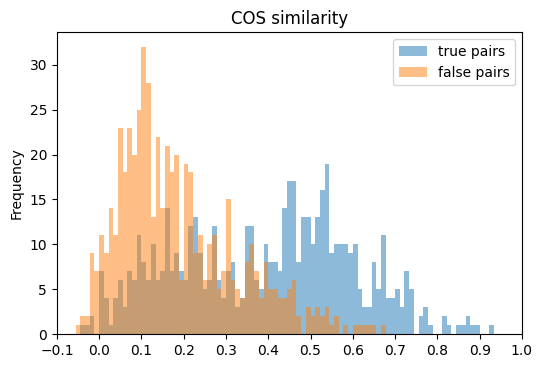

In [ ]:
bins = np.linspace(-0.1, 1, 100)
plt.figure(dpi=100)

plt.hist(all_true_pairssimlistCOStable[0], bins, alpha=0.5, label='true pairs')
plt.hist(all_false_pairssimlistCOStable[0], bins, alpha=0.5, label='false pairs')

plt.xlim(-0.1, 1.0)
plt.xticks(np.arange(-0.1, 1.01, step=0.1))

plt.ylabel("Frequency")
plt.legend(loc='upper right')
plt.title("COS similarity") 
plt.show()

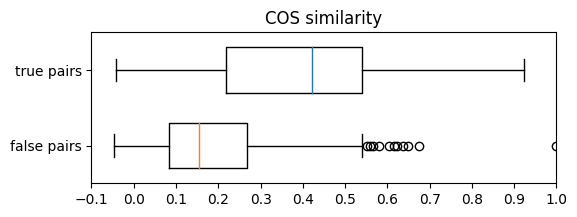

In [ ]:
fig, ax = plt.subplots(figsize=(6,2),dpi=100)

ax.set_title('COS similarity')

plt.xlim(0, 1)
plt.xticks(np.arange(-0.1, 1.01, step=0.1))

ax.boxplot(all_true_pairssimlistCOStable[0],positions= [1], medianprops=dict(color="C0"), vert= False, widths=0.6, labels = ['true pairs'])
ax.boxplot(all_false_pairssimlistCOStable[0],positions= [0], medianprops=dict(color="C1"), vert= False, widths=0.6, labels = ["false pairs"])

plt.show()

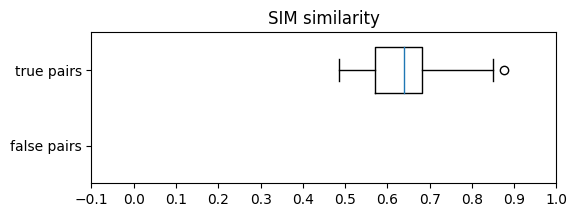

In [ ]:
fig, ax = plt.subplots(figsize=(6,2),dpi=100)

ax.set_title('SIM similarity')

plt.xlim(0, 1)
plt.xticks(np.arange(-0.1, 1.01, step=0.1))

ax.boxplot(all_true_pairssimlistSIMtable[0],positions= [1], medianprops=dict(color="C0"), vert= False, widths=0.6, labels = ['true pairs'])
ax.boxplot(all_false_pairssimlistSIMtable[0],positions= [0], medianprops=dict(color="C1"), vert= False, widths=0.6, labels = ["false pairs"])

plt.show()

# Getting best models for COS and SIM



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from keras.utils import to_categorical

In [ ]:
def create_train_test(df, test_size = 0.33):
  X = df[0]
  y = df['label']
  y = to_categorical(y)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=420)
  
  return X_train, X_test, y_train, y_test

In [ ]:
import matplotlib as mpl

def plot_confusion_matrix(cm, classes, normalize=False, cmap=mpl.cm.binary, title = None):
    plt.figure(dpi=100)
    if title:
      plt.title(title)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # if normalize:
    #     cm = cm.astype('float') / cm.sum(axis=1)[:np.newaxis]
    #     print('Normalized confusiom matrix')
    # else:
    #     print('Confusion matrix without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], 
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Prawdziwe')
    plt.xlabel('Przewidywane')
    plt.show()
cm_plot_labels = ['nie para', 'para']

In [ ]:
def create_fit_model(X_train, y_train, epochs, learning_rate, loss, metrics):
  model = tf.keras.Sequential([
    Dense(units=3, input_dim= 1, activation='relu'),
    Dense(units=3, activation='relu'),
    Dense(units=3, activation='relu'),
    Dense(units=2, activation='softmax')
  ])
  model.compile(optimizer=Adam(learning_rate= learning_rate), loss=loss, metrics=metrics)
  history = model.fit(x=X_train, y=y_train,shuffle=True, epochs=epochs, verbose=0)

  return history, model

In [ ]:
def predict(model, X_test, y_test):
  predictions = model.predict(x=X_test, verbose=0)
  defEncod_pred = np.argmax(predictions, axis=1)
  defEncod_labels = np.argmax(y_test, axis=1)
  cm = confusion_matrix(y_true = defEncod_labels, y_pred = defEncod_pred)
  f1 = sklearn.metrics.f1_score(defEncod_labels, defEncod_pred)
  return cm, f1

In [ ]:
averaging_iters = 5
epochs = 200

dfs = [all_pairssimlistCOStable, all_pairssimlistSIMtable]
sim_measure = ["cos", "sim"]

metrics_avg = {"cos":{"f1":0, "acc":0, "loss":0, "cm":np.zeros((2,2),dtype = int)}, "sim":{"f1":0, "acc":0, "loss":0, "cm": np.zeros((2,2),dtype = int)}}
metrics_max = {"cos":[], "sim":[]}
learning_rates = [0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]
f1acc_matrix = np.zeros((2,len(learning_rates), averaging_iters))
best_models1 = {"cos":[], "sim":[]}
# best_models = {"acc":{"cos":[], "sim":[]},"f1":{"cos":[], "sim":[]}}

mode = "max"

for simcos, df in zip(sim_measure, dfs):
  X_train, X_test, y_train, y_test = create_train_test(df)
  for i in range(averaging_iters):
    for j in range(len(learning_rates)):
      #create and fit a model
      history, model = create_fit_model(X_train, y_train, epochs, learning_rates[j], 'categorical_crossentropy', ['accuracy'])

      #evaluate model to get Accuracy and Loss on test set
      loss, acc = model.evaluate(X_test,y_test, verbose=0)

      #make predictions for a given model to get confusion matrix and f1
      cm, f1 = predict(model, X_test, y_test)

      #save metrics' scores
      if mode == "avg":
        metrics_avg[simcos]["acc"] += acc
        metrics_avg[simcos]["loss"] += loss
        metrics_avg[simcos]["f1"] += f1
        metrics_avg[simcos]['cm'] += cm

      if mode == "max":
        metrics_max[simcos].append([acc, loss, f1, cm, learning_rates[j]])
        f1acc_matrix[0,j,i] = acc
        f1acc_matrix[1,j,i] = f1

  if mode == "avg":
    #divide by number of iterations to get an average score
    metrics_avg[simcos]['cm'] = metrics_avg[simcos]['cm'] // averaging_iters
    metrics_avg[simcos]["acc"] /= averaging_iters
    metrics_avg[simcos]["loss"] /= averaging_iters
    metrics_avg[simcos]["f1"] /= averaging_iters

  if mode == "max":
    #choose models with the best accuracy and f1 score
    sum_f1acc_matrix = f1acc_matrix[0] + f1acc_matrix[1]
    bestmodel1_num = np.argmax(sum_f1acc_matrix.reshape(-1, order='F'))
    best_models1[simcos] = metrics_max[simcos][bestmodel1_num]

In [ ]:
best_models1

{'cos': [0.6773333549499512,
  0.6856050491333008,
  0.6666666666666666,
  array([[133,  63],
         [ 58, 121]]),
  1e-05],
 'sim': [0.6880000233650208, nan, 0.7180722891566265, array([[109,  74],
         [ 43, 149]]), 0.0001]}

# Best models overview




COS similarity measure
Accuracy: 0.6773333549499512
Loss: 0.6856050491333008
F1 score: 0.6666666666666666
Best learning rate: 1e-05
[[133  63]
 [ 58 121]]


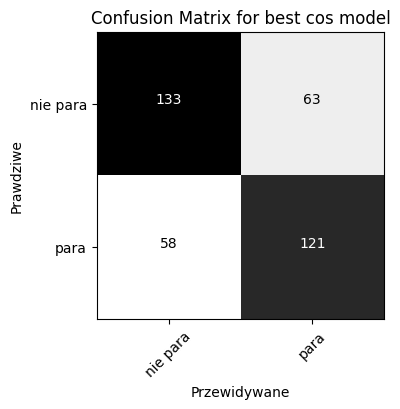


SIM similarity measure
Accuracy: 0.6880000233650208
Loss: nan
F1 score: 0.7180722891566265
Best learning rate: 0.0001
[[109  74]
 [ 43 149]]


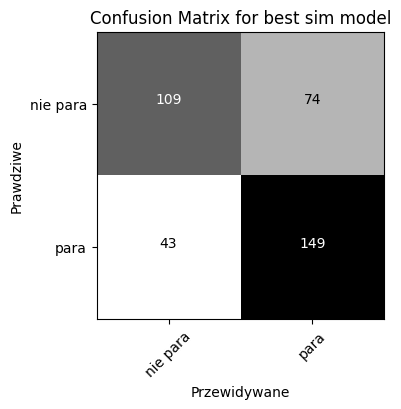

In [ ]:
for simcos in ["cos","sim"]:
  print(f"{simcos.upper()} similarity measure")
  print("Accuracy:",best_models1[simcos][0])
  print("Loss:",best_models1[simcos][1])
  print("F1 score:",best_models1[simcos][2])
  print("Best learning rate:",best_models1[simcos][4])
  plot_confusion_matrix(cm= best_models1[simcos][3] , classes=cm_plot_labels, title = f"Confusion Matrix for best {simcos} model")
  print("")

# Examples of training a model

using COS similarity measure

In [ ]:
X_train, X_test, y_train, y_test = create_train_test(all_pairssimlistCOStable)

In [ ]:
model1 = tf.keras.Sequential([
    Dense(units=3, input_dim= 1, activation='relu'),
    Dense(units=3, activation='relu'),
    Dense(units=3, activation='relu'),
    Dense(units=2, activation='softmax')
  ])
model1.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
history = model1.fit(x=X_train, y=y_train,shuffle=True, epochs=200, verbose=2)

Epoch 1/200
24/24 - 0s - loss: 0.6933 - accuracy: 0.4888
Epoch 2/200
24/24 - 0s - loss: 0.6931 - accuracy: 0.5231
Epoch 3/200
24/24 - 0s - loss: 0.6927 - accuracy: 0.5112
Epoch 4/200
24/24 - 0s - loss: 0.6925 - accuracy: 0.5112
Epoch 5/200
24/24 - 0s - loss: 0.6922 - accuracy: 0.5112
Epoch 6/200
24/24 - 0s - loss: 0.6919 - accuracy: 0.5112
Epoch 7/200
24/24 - 0s - loss: 0.6915 - accuracy: 0.5112
Epoch 8/200
24/24 - 0s - loss: 0.6910 - accuracy: 0.5112
Epoch 9/200
24/24 - 0s - loss: 0.6903 - accuracy: 0.5112
Epoch 10/200
24/24 - 0s - loss: 0.6895 - accuracy: 0.5112
Epoch 11/200
24/24 - 0s - loss: 0.6886 - accuracy: 0.5112
Epoch 12/200
24/24 - 0s - loss: 0.6874 - accuracy: 0.5112
Epoch 13/200
24/24 - 0s - loss: 0.6861 - accuracy: 0.5112
Epoch 14/200
24/24 - 0s - loss: 0.6846 - accuracy: 0.5112
Epoch 15/200
24/24 - 0s - loss: 0.6828 - accuracy: 0.5112
Epoch 16/200
24/24 - 0s - loss: 0.6808 - accuracy: 0.5112
Epoch 17/200
24/24 - 0s - loss: 0.6785 - accuracy: 0.5112
Epoch 18/200
24/24 - 0s

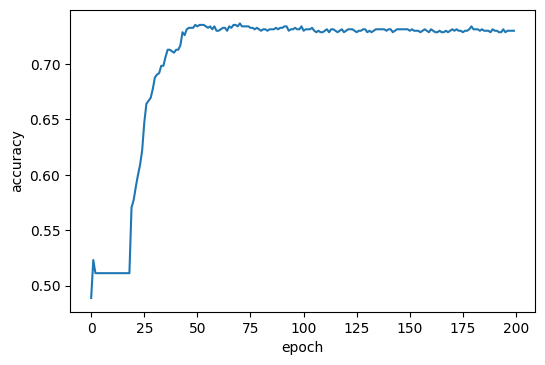

In [ ]:
plt.figure(dpi=100)
plt.plot(history.history['accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

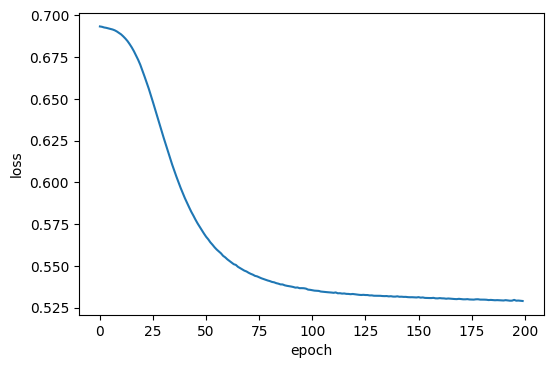

In [ ]:
plt.figure(dpi=100)
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, acc = model1.evaluate(X_test,y_test)

12/12 [==============================] - 0s 1ms/step - loss: 0.6015 - accuracy: 0.6827


In [ ]:
predictions = model1.predict(x=X_test, verbose=0)

roundedPredictions = np.argmax(predictions, axis=1)
rounded_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true = rounded_labels, y_pred = roundedPredictions)

In [ ]:
cm

array([[158,  38],
       [ 81,  98]])

In [ ]:
sklearn.metrics.f1_score(rounded_labels, roundedPredictions)

0.6222222222222221

[[158  38]
 [ 81  98]]


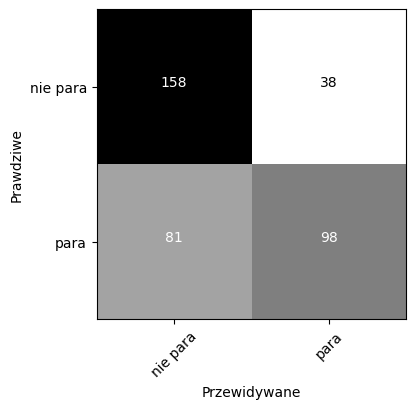

In [ ]:
plot_confusion_matrix(cm=cm, classes=['nie para', 'para'])

using SIM similarity measure

In [ ]:
X_train, X_test, y_train, y_test = create_train_test(all_pairssimlistSIMtable)

In [ ]:
model2 = tf.keras.Sequential([
    Dense(units=3, input_dim= 1, activation='relu'),
    Dense(units=3, activation='relu'),
    Dense(units=3, activation='relu'),
    Dense(units=2, activation='softmax')
  ])
model2.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
history = model2.fit(x=X_train, y=y_train,shuffle=True, epochs=200, verbose=2)

Epoch 1/200
24/24 - 0s - loss: 0.6908 - accuracy: 0.5007
Epoch 2/200
24/24 - 0s - loss: 0.6812 - accuracy: 0.5810
Epoch 3/200
24/24 - 0s - loss: 0.6687 - accuracy: 0.6166
Epoch 4/200
24/24 - 0s - loss: 0.6527 - accuracy: 0.6614
Epoch 5/200
24/24 - 0s - loss: 0.6134 - accuracy: 0.7286
Epoch 6/200
24/24 - 0s - loss: 0.5768 - accuracy: 0.7233
Epoch 7/200
24/24 - 0s - loss: 0.5559 - accuracy: 0.7286
Epoch 8/200
24/24 - 0s - loss: 0.5494 - accuracy: 0.7352
Epoch 9/200
24/24 - 0s - loss: 0.5461 - accuracy: 0.7286
Epoch 10/200
24/24 - 0s - loss: 0.5417 - accuracy: 0.7365
Epoch 11/200
24/24 - 0s - loss: 0.5399 - accuracy: 0.7260
Epoch 12/200
24/24 - 0s - loss: 0.5427 - accuracy: 0.7391
Epoch 13/200
24/24 - 0s - loss: 0.5561 - accuracy: 0.7233
Epoch 14/200
24/24 - 0s - loss: 0.5637 - accuracy: 0.7260
Epoch 15/200
24/24 - 0s - loss: 0.5451 - accuracy: 0.7312
Epoch 16/200
24/24 - 0s - loss: 0.5407 - accuracy: 0.7312
Epoch 17/200
24/24 - 0s - loss: 0.5382 - accuracy: 0.7497
Epoch 18/200
24/24 - 0s

In [ ]:
model2.evaluate(X_test,y_test)

12/12 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.6907


[nan, 0.690666675567627]

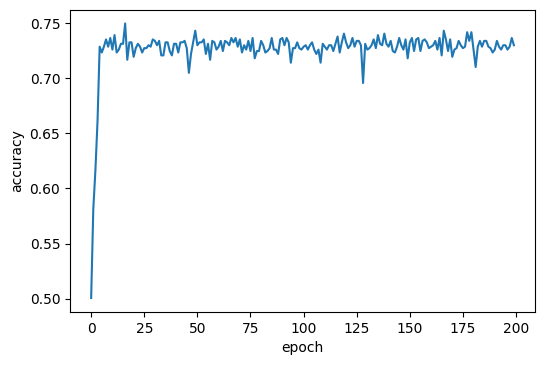

In [ ]:
plt.figure(dpi=100)
plt.plot(history.history['accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

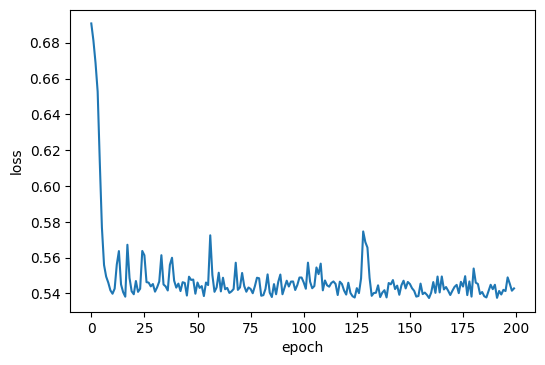

In [ ]:
plt.figure(dpi=100)
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
predictions = model2.predict(x=X_test, verbose=0)

roundedPredictions = np.argmax(predictions, axis=1)
rounded_labels=np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true = rounded_labels, y_pred = roundedPredictions)

In [ ]:
sklearn.metrics.f1_score(rounded_labels, roundedPredictions)

0.6914893617021278

[[129  54]
 [ 62 130]]


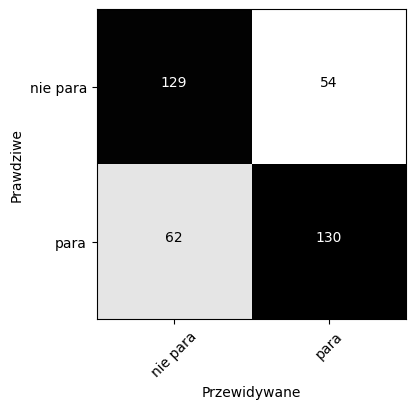

In [ ]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels)

#Code junkyard

In [ ]:
# def save_metricsscores(mode, metrics_avg, f1acc_matrix, cm, f1, history):
#   if mode == "avg":
#         metrics_avg[simcos]["acc"] += history.history['accuracy'][-1]
#         metrics_avg[simcos]["loss"] += history.history['loss'][-1]
#         metrics_avg[simcos]["f1"] += f1
#         metrics_avg[simcos]['cm'] += cm
  
#    if mode == "max":
#         metrics_max[simcos].append([history.history['accuracy'][-1], history.history['loss'][-1], f1, cm, learning_rates[j]])
#         f1acc_matrix[0,j,i] = history.history['accuracy'][-1]
#         f1acc_matrix[1,j,i] = f1
    
#   return metrics_max, f1acc_matrix

In [ ]:
# for simcos in ["cos","sim"]:
#   for metr in ["acc","f1"]:
#     print(f"{simcos.upper()} similarity measure")
#     print("Accuracy:",best_models[metr][simcos][0])
#     print("Loss:",best_models[metr][simcos][1])
#     print("F1 score:",best_models[metr][simcos][2])
#     print("Best learning rate:",best_models[metr][simcos][4])
#     plot_confusion_matrix(cm= best_models[metr][simcos][3] , classes=cm_plot_labels, title = f"{simcos} {metr}")
#     print("")

In [ ]:


      # model = tf.keras.Sequential([
      #   Dense(units=3, input_dim= 1, activation='relu'),
      #   Dense(units=3, activation='relu'),
      #   Dense(units=3, activation='relu'),
      #   Dense(units=2, activation='softmax')
      # ])
      # model.compile(optimizer=Adam(learning_rate= learning_rates[j]), loss='categorical_crossentropy', metrics=['accuracy'])
      # #fit model
      # history = model.fit(x=X_train, y=y_train,shuffle=True, epochs=epochs, verbose=0)



      #predict and create a confusion matrix
      # predictions = model.predict(x=X_test, verbose=0)
      # defEncod_pred = np.argmax(predictions, axis=1)
      # defEncod_labels = np.argmax(y_test, axis=1)
      # cm = confusion_matrix(y_true = defEncod_labels, y_pred = defEncod_pred)



      # print("acc")
      # print(history.history['accuracy'][-1])
      # print("loss")
      # print(history.history['loss'][-1])
      # print("f1")
      # print(sklearn.metrics.f1_score(defEncod_labels, defEncod_pred))


In [ ]:

    # bestmodel_num = np.argmax(f1acc_matrix[0].reshape(-1, order='F'))
    # best_models['acc'][simcos] = metrics_max[simcos][bestmodel_num]
    # bestmodel_num = np.argmax(f1acc_matrix[1].reshape(-1, order='F'))
    # best_models['f1'][simcos] = metrics_max[simcos][bestmodel_num]